In [151]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [101]:
df = pd.read_csv('Data/USArrests.csv', index_col=0)
#names = list(df.columns)
#names[0] = 'City'
#df.columns = names
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.8+ KB


In [102]:
#df.drop('City', axis=1).mean()
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [103]:
#df.drop('City', axis=1).var()
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [143]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [144]:
pca = PCA(n_components=None)
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [145]:
pca_loadings = pd.DataFrame(pca.components_.T, 
                            index=df.columns,
                            columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_loadings

               PC1       PC2       PC3       PC4
Murder   -0.535899  0.418181 -0.341233  0.649228
Assault  -0.583184  0.187986 -0.268148 -0.743407
UrbanPop -0.278191 -0.872806 -0.378016  0.133878
Rape     -0.543432 -0.167319  0.817778  0.089024

In [180]:
df_plot = pd.concat([(X*pca_loadings.PC1).sum(axis=1),(X*pca_loadings.PC2).sum(axis=1)], axis=1, keys=['PC1', 'PC2'])
df_plot.head()

                 PC1       PC2
Alabama     0.985566 -1.133392
Alaska      1.950138 -1.073213
Arizona     1.763164  0.745957
Arkansas   -0.141420 -1.119797
California  2.523980  1.542934

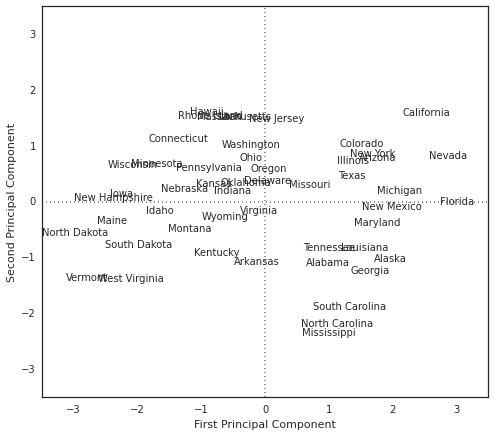

In [198]:
plt.figure(figsize=(8,7))
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)

for i in df_plot.index:
    plt.annotate(i, (-df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

plt.plot(pca_loadings)    

    
plt.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
plt.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')


In [252]:
pca.explained_variance_

array([ 2.48024158,  0.98976515,  0.35656318,  0.17343009])

In [253]:
pca.explained_variance_ratio_

array([ 0.62006039,  0.24744129,  0.0891408 ,  0.04335752])